In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalBoosting import MeanFieldVariationalMixtureDistribution
from Tools.NNtools import *

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [5]:
model = nn.Sequential( nn.Linear(1, 50),
                       nn.Tanh(), 
                       nn.Linear(50, 1),
                     ).to(device)

In [6]:
param_count = get_param(model).shape[0]

In [7]:
flip_parameters_to_tensors(model)

In [8]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [9]:
def logprior(x):
    return prior.log_prob(x)

In [10]:
def loglikelihood(theta, model, x, y, sigma_noise):
    def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [11]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [12]:
def Boost(qC, n_samples_ELBO):
    qC.requires_grad_(False)
    for c in qC.components:
        c.mu.detach_()
        c.rho.detach_()
        
    with torch.no_grad():  
        Ln = []
        for j in range(10000):
            z = q.sample(1)
            LQ = qC.log_prob(z)
            LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
            Ln.append(LQ - LP)
        baseline = torch.stack(Ln).mean()
        Ln = []
    print(baseline)
    
    std = torch.distributions.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).sample()[0].float()
    
    q_new = MeanFieldVariationalDistribution(param_count, sigma=0.0000001, device=device)
    unbounded_prop_new = torch.tensor(2.0, device=device).requires_grad_(True)

    q_new.mu = nn.Parameter( torch.empty([1,param_count],device=device).normal_(std=std), requires_grad=True)
    #q_new.mu = nn.Parameter(prior.sample()[0,:].detach().clone().to(device), requires_grad=True) 

    q_new.rho.requires_grad = True
    q_new.mu.requires_grad = True
    
    optimizer = torch.optim.Adam(list(q_new.parameters())+[unbounded_prop_new], lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.9)

    %matplotlib inline
    liveloss = PlotLosses()
    for t in range(1000):
        logs = {}
        optimizer.zero_grad()

        Ln = []
        for j in range(n_samples_ELBO):
            Xc = qC.sample(1)
            Xnew = q_new.sample(1)
            prop_new = torch.sigmoid(unbounded_prop_new)

            v = -(1-prop_new)*torch.mean(logposterior(Xc, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xc, q_new, unbounded_prop_new)) - \
            prop_new*torch.mean(logposterior(Xnew, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xnew, q_new, unbounded_prop_new))

            Ln.append(v)
            
        L = torch.stack(Ln).mean()
        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        logs['ELBO'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        liveloss.update(logs)

        if t % 10 == 0:
            liveloss.draw()

        optimizer.step()

        if learning_rate < 0.001:
            break

    with torch.no_grad():
        for j in range(1000):
            Xc = qC.sample(1)
            Xnew = q_new.sample(1)
            prop_new = torch.sigmoid(unbounded_prop_new)

            v = -(1-prop_new)*torch.mean(logposterior(Xc, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xc, q_new, unbounded_prop_new)) - \
            prop_new*torch.mean(logposterior(Xnew, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xnew, q_new, unbounded_prop_new))

            Ln.append(v)
            
        score = torch.stack(Ln).mean()
    print(score)
            
    if score < baseline:
        components = qC.components + [q_new]
        proportions = torch.cat([(1-torch.sigmoid(unbounded_prop_new))*qC.proportions, torch.tensor([torch.sigmoid(unbounded_prop_new)],device=device)]).detach()

        qC_new = MeanFieldVariationalMixtureDistribution(proportions, components, device=device)
    else:
        qC_new = qC
    return qC_new

# Variational Distribution #

In [13]:
std = torch.distributions.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).sample()[0].float()
q = MeanFieldVariationalDistribution(param_count, sigma=0.0000001, device=device)
q.mu = nn.Parameter( torch.empty([1,param_count],device=device).normal_(std=std), requires_grad=True)
q.rho.requires_grad = True
q.mu.requires_grad = True

In [14]:
q.mu.detach_().requires_grad_(True)
q.rho.detach_().requires_grad_(True);

In [15]:
n_samples_ELBO = 100

In [16]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.9)

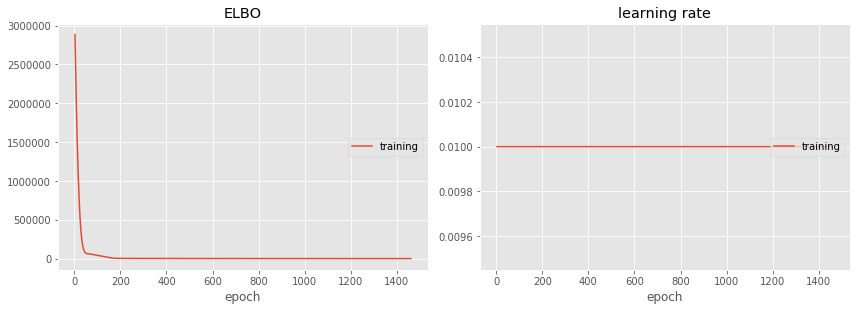

ELBO:
training   (min:  474.953, max: 3229988.750, cur:  481.211)

learning rate:
training   (min:    0.010, max:    0.010, cur:    0.010)


KeyboardInterrupt: 

In [17]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    Ln = []
    for j in range(n_samples_ELBO):
        z = q.sample(1)
        LQ = q.log_prob(z)
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        Ln.append(LQ - LP)

    L = torch.stack(Ln).mean()
    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.001:
        break

In [18]:
components = [q]
proportions = torch.tensor([1.0], device=device)
qC = MeanFieldVariationalMixtureDistribution(proportions, components, device=device)

In [19]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)

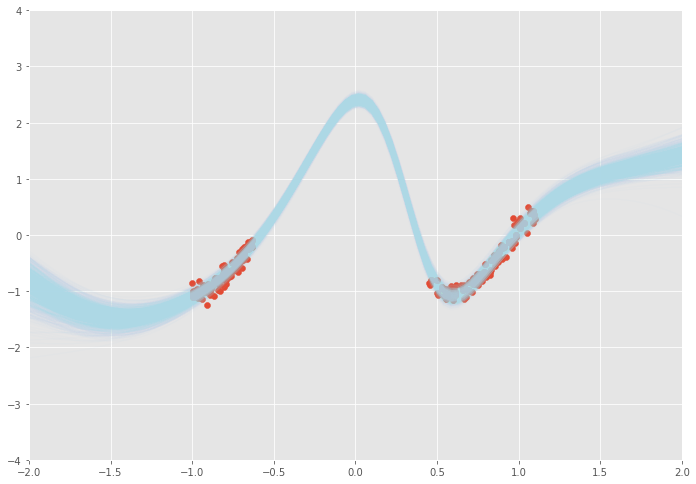

In [20]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = qC.sample()
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [21]:
qC.proportions

tensor([1.])

In [22]:
qC = Boost(qC, 100)

tensor(186.7290)


RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 2 and 3 at c:\n\pytorch_1559129895673\work\aten\src\th\generic/THTensorMoreMath.cpp:1298

In [ ]:
qC = Boost(qC, 100)

In [ ]:
qC = Boost(qC, 100)

In [ ]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = qC.sample()
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')